In [1]:
#import sys; sys.path.append('/notebooks')

# Autoencoders

In [1]:
import pickle, gzip, math, os, time, shutil
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter, itemgetter
from functools import partial

import torch
from torch import tensor, nn, optim
from torch.utils.data import DataLoader, default_collate
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from datasets import load_dataset, load_dataset_builder
from tqdm.auto import tqdm, trange

from fastprogress import progress_bar, master_bar
from miniai.datasets import * 
from miniai.training import * 
from miniai.conv import *

In [4]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
plt.style.use('fast')

torch_device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available else 'cpu'
device = torch.device(torch_device)

import logging
logging.disable(logging.WARNING)
torch.manual_seed(42);

## Data

In [5]:
x, y = 'image', 'label'
name = 'fashion_mnist'
dsd = load_dataset(name)

  0%|          | 0/2 [00:00<?, ?it/s]

In [6]:
@inplace
def transformi(b): b[x] = [TF.to_tensor(o) for o in b[x]]

In [7]:
bs = 256
tds = dsd.with_transform(transformi)

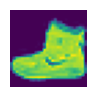

In [8]:
ds = tds['train']
img = ds[0][x]
show_image(img, figsize=(1, 1));

In [9]:
cf = collate_dict(ds)

In [10]:
def collate_(b): return to_device(cf(b))
def data_loaders(dsd, bs, **kwargs): 
    return {k: DataLoader(v, bs, **kwargs) for k, v in dsd.items()}

In [11]:
dls = data_loaders(tds, bs, collate_fn=collate_)

In [12]:
dt = dls['train']
dv = dls['test']

xb, yb = next(iter(dt))

In [13]:
labels = ds.features[y].names
labels

['T - shirt / top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [14]:
n = 16
label_getter = itemgetter(*yb[:n])
titles = label_getter(labels)
titles

('Ankle boot',
 'T - shirt / top',
 'T - shirt / top',
 'Dress',
 'T - shirt / top',
 'Pullover',
 'Sneaker',
 'Pullover',
 'Sandal',
 'Sandal',
 'T - shirt / top',
 'Ankle boot',
 'Sandal',
 'Sandal',
 'Sneaker',
 'Ankle boot')

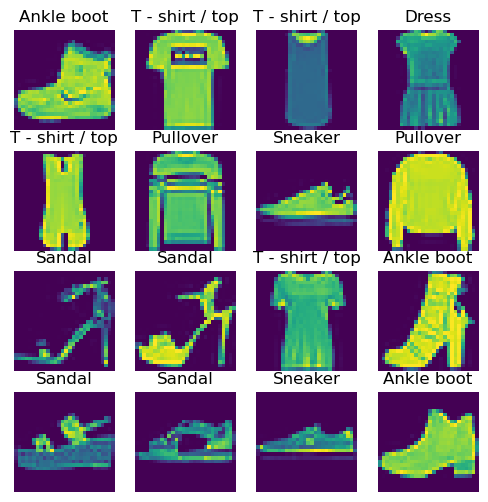

In [15]:
show_images(xb[:n], imsize=1.5, titles=titles)

# Let's get warmed up 🔥

In [16]:
from torch import optim

In [17]:
bs = 256
lr = 0.5

In [18]:
torch.manual_seed(42)
cnn = nn.Sequential(
    conv(1, 4),   # 14x14
    conv(4, 8),   # 7x7
    conv(8, 16),  # 4x4
    conv(16, 32), # 2x2
    conv(32, 10, act=False),
    nn.Flatten()

).to(device)

opt = optim.SGD(cnn.parameters(), lr=0.3)
loss, acc = fit(5, cnn, F.cross_entropy, opt, dt, dv)

  0%|          | 0/5 [00:00<?, ?it/s]

0 0.7122553621292115 0.7405
1 0.5197683117866516 0.8146
2 0.48882004475593566 0.8241
3 0.46405123248100283 0.8356
4 0.4364419476985931 0.8407


In [19]:
dsd['train'][0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
 'label': 9}

# Autoencoders 🚀

## Transpose Convolutions a.k.a "Deconvolutions" (not)

For more see here:
https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md

https://medium.com/@marsxiang/convolutions-transposed-and-deconvolution-6430c358a5b6

Explained in detail: https://arxiv.org/pdf/1603.07285.pdf

Biggest difference between Upsampling and Transponse convolution is that upsampling has no trainable parameters

In [18]:
def deconv(ni, nf, ks=3, act=True): 
    # Later we should try it with a transpose conv
    layers = [nn.UpsamplingNearest2d(scale_factor=2),
             nn.Conv2d(ni, nf, stride=1, kernel_size=ks, padding=ks//2)] # this just preserves dimension
    if act: layers.append(nn.ReLU())
    return nn.Sequential(*layers)

In [26]:
def eval(model, loss_func, valid_dl, epoch=0):
    model.eval()
    with torch.no_grad():
        tot_loss, count = 0., 0
        for xb, _ in valid_dl:
            pred = model(xb)
            n = len(xb)
            count += n
            tot_loss += loss_func(pred, xb).item()*n
    print(epoch, f'{tot_loss/count:.3f}')

In [20]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in trange(epochs):
        model.train()
        for xb, _ in train_dl:
            loss = loss_func(model(xb), xb) # this is the autoencoder bit
            loss.backward()
            opt.step()
            opt.zero_grad()
        eval(model, loss_func, valid_dl, epoch)            

In [21]:
torch.manual_seed(42)
auto_encoder = nn.Sequential( # 28x28
    nn.ZeroPad2d(2), # 32x32
    conv(1, 2), # 16x16
    conv(2, 4), # 8x8
    conv(4, 8), # 4x4
    deconv(8, 4), # 8x8
    deconv(4, 2), # 16, 16
    deconv(2, 1, act=False), # 32x32
    nn.ZeroPad2d(-2), # 28x28
    nn.Sigmoid()
).to(device)

In [22]:
activations = {}
def get_activation(name, idx):
    def hook(model, input, output):
        activations[name][idx] = output.detach()
        return output
    return hook

In [27]:
a = 1+1
print(a)

2


In [23]:
def add_hooks(model, name):
    for i, layer in enumerate(model):
        if name not in activations:
            activations[name] = {}

        model[i].register_forward_hook(get_activation(name, i))

In [24]:
add_hooks(auto_encoder, 'orig')

In [25]:
eval(auto_encoder, F.mse_loss, dv)

0 0.152


In [26]:
opt = optim.SGD(auto_encoder.parameters(), lr=0.1)
fit(5, auto_encoder, F.mse_loss, opt, dt, dv)

  0%|          | 0/5 [00:00<?, ?it/s]

0 0.124
1 0.112
2 0.053
3 0.042
4 0.037


In [27]:
opt = optim.SGD(auto_encoder.parameters(), lr=0.01)
fit(5, auto_encoder, F.mse_loss, opt, dt, dv)

  0%|          | 0/5 [00:00<?, ?it/s]

0 0.036
1 0.036
2 0.036
3 0.035
4 0.035


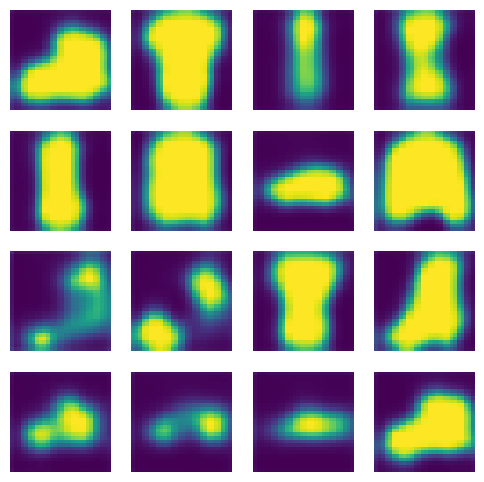

In [28]:
preds = auto_encoder(xb)
show_images(preds[:n], imsize=1.5)

In [29]:
def show_activations(model, name, i):
    for layer in range(len(model)):
        show_images(activations[name][layer][i].unsqueeze(1), imsize=1, titles=[f"Layer {layer}"])    

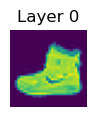

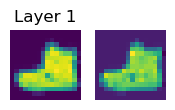

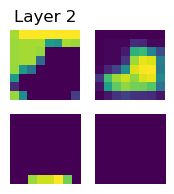

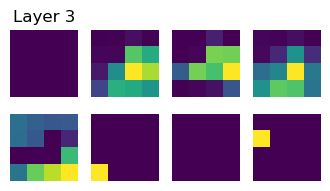

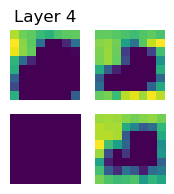

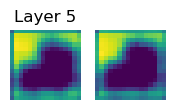

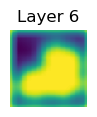

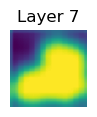

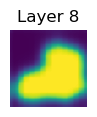

In [30]:
show_activations(auto_encoder, 'orig', 0)

### Let's try transpose convolutions

In [31]:
def convT(ni, nf, ks=4, act=True): 
    layers = [nn.ConvTranspose2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2 - 1)]
    if act: layers.append(nn.ReLU())
    return nn.Sequential(*layers) 

In [32]:
t = torch.randn(1, 8, 4, 4)

In [33]:
t.shape

torch.Size([1, 8, 4, 4])

In [34]:
t = convT(8, 4)(t)
t.shape

torch.Size([1, 4, 8, 8])

In [35]:
t = convT(4, 2)(t)
t.shape

torch.Size([1, 2, 16, 16])

In [36]:
t = convT(2, 1)(t)
t.shape

torch.Size([1, 1, 32, 32])

In [65]:
torch.manual_seed(42)
auto_encoder2 = nn.Sequential( # 28x28
    nn.ZeroPad2d(2), # 32x32
    conv(1, 2), # 16x16
#    conv(2, 4), # 8x8
#    conv(4, 8), # 4x4
#    conv(8, 16), # 2x2
#    convT(16, 8),# 4x4
#    convT(8, 4), # 8x8
#    convT(4, 2), # 16x16
    convT(2, 1), # 32x32
    nn.ZeroPad2d(-2), #28x28
    nn.Sigmoid()
).to(device)

In [66]:
add_hooks(auto_encoder2, 'new')

In [67]:
opt = optim.SGD(auto_encoder2.parameters(), lr=1)
fit(10, auto_encoder2, F.mse_loss, opt, dt, dv)

  0%|          | 0/10 [00:00<?, ?it/s]

0 0.165
1 0.164
2 0.164
3 0.164
4 0.163
5 0.163
6 0.163
7 0.163
8 0.163
9 0.163


In [68]:
opt = optim.Adam(auto_encoder2.parameters(), lr=0.15)
fit(20, auto_encoder2, F.mse_loss, opt, dt, dv)

  0%|          | 0/20 [00:00<?, ?it/s]

0 0.163
1 0.163
2 0.163
3 0.163
4 0.163
5 0.163
6 0.163
7 0.163
8 0.163
9 0.163
10 0.163
11 0.163
12 0.163
13 0.163
14 0.163
15 0.163
16 0.163
17 0.163
18 0.169
19 0.163


In [63]:
preds = auto_encoder2(xb)

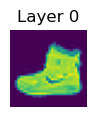

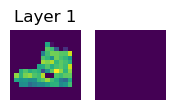

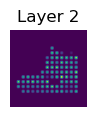

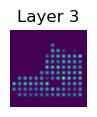

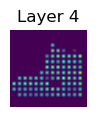

In [64]:
show_activations(auto_encoder2, 'new', 0)